In [1]:
# ===== Imports =====
import pandas as pd
from datetime import date, timedelta
import yfinance as yf
import csv
import os
import matplotlib.pyplot as plt

In [2]:
# ===== CONFIG =====
TRANSACTIONS_FILE = "transactions_sample.csv"
HISTORY_FILE = "portfolio_history.csv"

In [3]:
# ===== Load Data =====
df = pd.read_csv(TRANSACTIONS_FILE)

# Convert date to datetime
df["date"] = pd.to_datetime(df["date"])

# Convert numeric columns to numbers
numeric_cols = ["price", "quantity", "amount"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

In [4]:
# Transactions filters 

def get_investment_transactions(df):
    investments = df[df["type"] == 'investment']
    return investments

def get_expense(df):
    expenses = df[df["type"] == 'expense']
    return expenses

def get_income(df):
    income = df[df["type"] == 'income']
    return income

def filter_by_date(df, start, end):
    filtered_df = df[
        (df["date"] >= start) &
        (df["date"] <= end)
    ]
    return filtered_df

In [5]:
# ===== Holdings Construction =====
# Construct holdings table from transactions data.

def build_holdings(df):
    # Group by ticker, sum quantities and amounts
    group = df.groupby("ticker").agg({
        "asset": "first",
        "quantity": "sum",
        "amount": "sum"
    })
    
    # Keep only tickers with positive holdings
    holdings = group[group["quantity"] > 0].copy()
    
    # Average purchase price
    holdings["avg_price"] = abs(holdings["amount"] / holdings["quantity"])
    
    # Capital invested: sum of all cash outflows (buys)
    capital_invested = (
        df[df["amount"] < 0]    # buys are negative
        .groupby("ticker")["amount"]
        .sum()
    )
    
    # Reindex to match holdings index (in case of missing tickers)
    holdings["capital_invested"] = abs(
        capital_invested.reindex(holdings.index)
    )
    
    holdings = holdings.drop(columns=["amount"])
    return holdings

In [6]:
# Fetching Live Prices

def fetch_live_prices(tickers): # Parameter: List of tickers
    prices = [] # Empty list to store live prices
    for ticker in tickers:
        try:
            obj = yf.Ticker(ticker)
            prices.append(round(obj.fast_info["last_price"],2))
        except Exception:
            prices.append(None)
    return prices

In [7]:
# ===== Portfolio Metrics =====

def compute_portfolio_metrics(holdings):
    total_capital = holdings["capital_invested"].sum()
    total_market = holdings["market_value"].sum()
    total_pnl = round(holdings["unrealised_pnl"].sum(),2)
    pnl_pct = round((total_pnl / total_capital) * 100,2)
    
    data = {
        "total_capital_invested": [total_capital],
        "total_market_value": [total_market],
        "total_unrealised_pnl": [total_pnl],
        "portfolio_pnl_pct": [pnl_pct]
    }
    portfolio_df = pd.DataFrame(data)
    return portfolio_df

In [8]:
# ===== MAIN PROCESSING =====

# Filter investment transactions
investment_df = get_investment_transactions(df)[
    ["asset", "ticker", "price", "quantity", "amount"]
]

# Build holdings table
holdings = build_holdings(investment_df)

# Fetch live market prices
tickers = holdings.index.tolist()
holdings["current_price"] = fetch_live_prices(tickers)

# Calculate market value per holding
holdings["market_value"] = holdings["quantity"] * holdings["current_price"]

# Compute unrealised P/L per holding
holdings["unrealised_pnl"] = (
    holdings["current_price"] - holdings["avg_price"]
) * holdings["quantity"]

# Unrealised P/L % per holding
holdings["unrealised_pnl_pct"] = round(
    holdings["unrealised_pnl"] / holdings["capital_invested"] * 100,
    2
)

# Portfolio weight per holding
holdings["weight"] = round(
    holdings["market_value"] / holdings["market_value"].sum() * 100,
    2
)

# Compute portfolio summary metrics
portfolio_summary = compute_portfolio_metrics(holdings)

In [9]:
# Monthly Snapshots Storage

# CSV file path
file_path = "portfolio_history.csv"

# Header Row
snapshot_header = [
    "month",
    "total_capital_invested",
    "total_market_value",
    "total_unrealised_pnl",
    "portfolio_pnl_pct"
]

# Creates a new csv file if it doesn't exist
if not os.path.exists(file_path):
    with open(file_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(snapshot_header)
        print("CSV created with header.")

# Add snapshots to CSV file  
def add_snapshot(data):
    file_path = "portfolio_history.csv"
    
    # read existing months
    with open(file_path, "r", newline="") as file:
        reader = csv.reader(file)
        next(reader, None) # skip header
        existing_months = [row[0].strip() for row in reader]
    
    # skip duplicate
    if snapshot[0].strip() in existing_months:
        print(f"Snapshot for {snapshot[0]} already exists. Skipping")
        return
    
    # append snapshot
    with open(file_path, "a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(snapshot)
    
    print(f"Snapshot for {snapshot[0]} added.")

In [ ]:
# Monthly snapshot YYYY-MM
snapshot_date = '2026-05'

snapshot = [
    snapshot_date,
    portfolio_summary.loc[0, "total_capital_invested"],
    portfolio_summary.loc[0, "total_market_value"],
    portfolio_summary.loc[0, "total_unrealised_pnl"],
    portfolio_summary.loc[0, "portfolio_pnl_pct"]
]

# Call add_snapshot function 
add_snapshot(snapshot)

In [10]:
# Display table

display_df = holdings.copy()
display_df["avg_price"] = round(display_df["avg_price"],2)
display_df["unrealised_pnl_pct"] = display_df["unrealised_pnl_pct"].map("{:.2f}%".format)
display_df["weight"] = display_df["weight"].map("{:.2f}%".format)

display(display_df)
portfolio_summary

,asset,quantity,avg_price,capital_invested,current_price,market_value,unrealised_pnl,unrealised_pnl_pct,weight
ticker,,,,,,,,,
AAPL,Apple Inc,12.0,174.58,2725,267.58,3210.96,1115.96,40.95%,10.01%
AMZN,Amazon.com Inc,16.0,145.00,2320,233.57,3737.12,1417.12,61.08%,11.65%
GOOGL,Alphabet Inc,13.0,138.46,1800,316.19,4110.47,2310.47,128.36%,12.82%
META,Meta Platforms Inc,8.0,307.50,2460,661.74,5293.92,2833.92,115.20%,16.51%
MSFT,Microsoft Corp,10.0,334.00,3340,474.43,4744.30,1404.30,42.04%,14.79%
NVDA,NVIDIA Corp,16.0,117.19,2475,187.87,3005.92,1130.92,45.69%,9.37%
QQQ,Invesco QQQ Trust,4.0,397.50,1590,618.78,2475.12,885.12,55.67%,7.72%
SPY,SPDR S&P 500 ETF,6.0,466.67,2800,688.59,4131.54,1331.54,47.56%,12.88%
TSLA,Tesla Inc,3.0,230.00,1250,454.82,1364.46,674.46,53.96%,4.25%


,total_capital_invested,total_market_value,total_unrealised_pnl,portfolio_pnl_pct
0,20760,32073.81,13103.81,63.12


In [11]:
# Load historical snapshots
snapshots_df = pd.read_csv("portfolio_history.csv")
snapshots_df["date"] = pd.to_datetime(snapshots_df["month"])

# Sort by month
snapshots_df = snapshots_df.sort_values("date")

In [12]:
# ===== VALIDATIONS =====

def run_validations(df, holdings):
    checks = {}
    
    checks["no_negative_prices"] = (df["price"] > 0).all()
    checks["market_value_correct"] = (holdings["market_value"] == holdings["quantity"] * holdings["current_price"]).all()
    
    checks["no_negative_holdings"] = (holdings["quantity"] >= 0).all()
    checks["weights_sum_to_100"] = abs(holdings["weight"].sum() - 100) < 0.01
    
    return checks

run_validations(investment_df, holdings) 

{'no_negative_prices': np.True_,
 'market_value_correct': np.True_,
 'no_negative_holdings': np.True_,
 'weights_sum_to_100': np.True_}

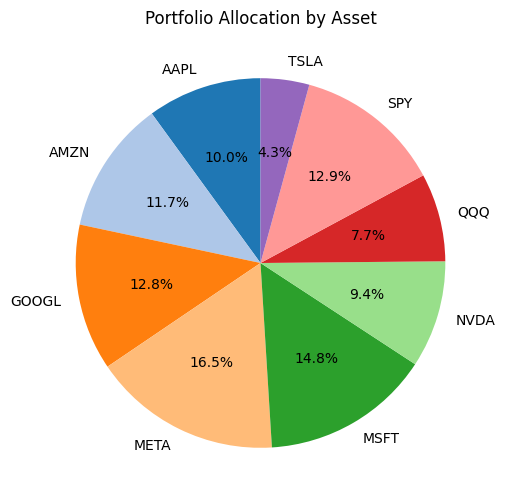

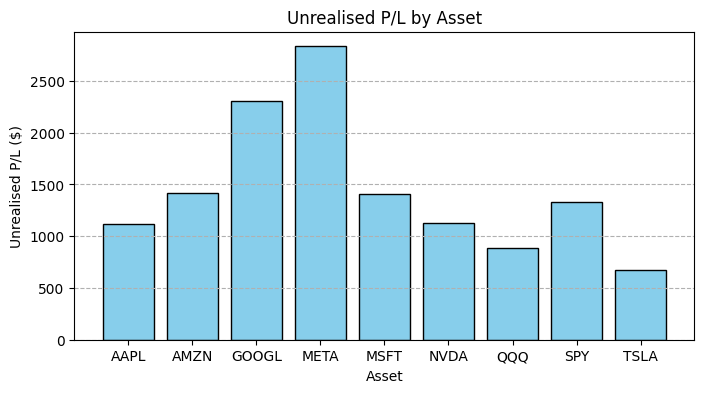

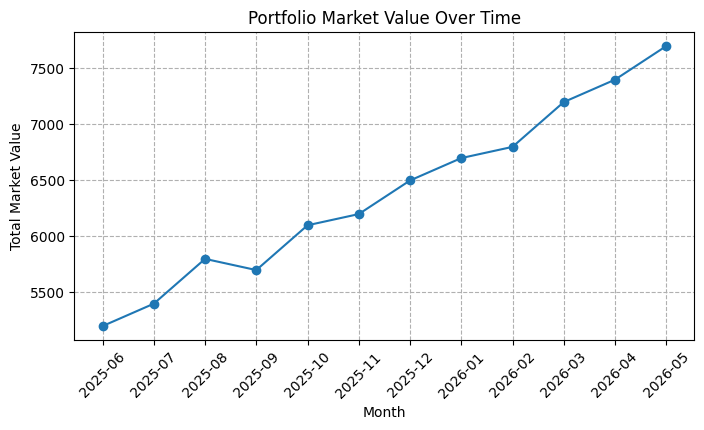

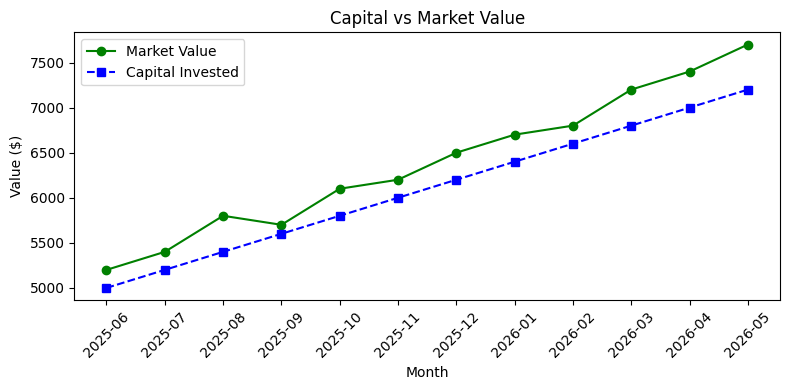

In [13]:
# ===== VISUALISATIONS =====

# Pie chart: Portfolio allocation by market value

plt.figure(figsize=(6,6))
plt.pie(
    holdings["market_value"],
    labels=holdings.index, 
    autopct="%.1f%%",
    startangle=90,
    colors = plt.cm.tab20.colors
)
plt.title("Portfolio Allocation by Asset")
plt.show()

# Bar chart: Unrealised P/L by asset

plt.figure(figsize=(8,4))
plt.bar(
    holdings.index, 
    holdings["unrealised_pnl"],
    color = 'skyblue',
    edgecolor = 'black'
)
plt.xlabel("Asset")
plt.ylabel("Unrealised P/L ($)")
plt.title("Unrealised P/L by Asset")
plt.grid(axis='y', linestyle='--')
plt.show()

# Line chart: Portfolio market value over time

plt.figure(figsize=(8,4))
plt.plot(
    snapshots_df["month"], 
    snapshots_df["total_market_value"],
    marker = 'o'
)

plt.title("Portfolio Market Value Over Time")
plt.xlabel("Month")
plt.ylabel("Total Market Value")
plt.grid(True,linestyle='--')
plt.xticks(rotation=45)
plt.show()

# Line chart: Capital invested vs Market value  

plt.figure(figsize=(8,4))
plt.plot(
    snapshots_df["month"], 
    snapshots_df["total_market_value"],
    marker = 'o',
    linestyle = '-',
    color = 'green',
    label = 'Market Value'
)
plt.plot(
    snapshots_df["month"], 
    snapshots_df["total_capital_invested"],
    marker = 's',
    linestyle = '--',
    color = 'blue',
    label = 'Capital Invested'
)
plt.legend()
plt.title("Capital vs Market Value")
plt.xlabel("Month")
plt.ylabel("Value ($)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()